# **About Dataset**

This dataset contains **18K job descriptions** out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent.

# **Data Gathering and Exploring**

In [10]:
# Import Libraries
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import re
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, RNN, Dense, Dropout, Bidirectional, SimpleRNN, SpatialDropout1D
from transformers import BertTokenizer, TFBertModel
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler


# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [11]:
# Load the Dataset
df = pd.read_csv('/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv')

In [12]:
# Get the dimensions of the Dataset
print("Dimensions of the Dataset (Rows, Columns):")
df.shape

Dimensions of the Dataset (Rows, Columns):


(17880, 18)

In [13]:
# Display the Initial rows in dataset
print("Initial rows in in dataset:")
df.head()

Initial rows in in dataset:


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [14]:
# Removing any leading, and trailing whitespaces in columns
df.columns = df.columns.str.strip()

In [15]:
# Getting an overview of the features and their types in the dataset
print("Overview of the features and their types:")
df.info()

Overview of the features and their types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry   

In [16]:
# Count the number of columns with dtype 'object'
object_cols = df.select_dtypes(include=['object']).columns
num_object_cols = len(object_cols)

# Count the number of columns with dtype 'int64'
int_cols = df.select_dtypes(include=['int64']).columns
num_int_cols = len(int_cols)

print(f"Number of columns with object dtype: {num_object_cols}")
print(f"Number of columns with int64 dtype: {num_int_cols}")

Number of columns with object dtype: 13
Number of columns with int64 dtype: 5


> Majority of features is Categorical Features

**Dealing with Missing Values**

In [17]:
# Check for missing values
print('Null Values in Each Column:\n')
print(df.isnull().sum())

Null Values in Each Column:

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


In [18]:
# View percentage of missing values per column
print('Percent of Null Values in Each Column:\n')
print(df.isnull().mean() * 100)

Percent of Null Values in Each Column:

job_id                  0.000000
title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.078300
benefits               40.335570
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.412752
required_experience    39.429530
required_education     45.329978
industry               27.421700
function               36.101790
fraudulent              0.000000
dtype: float64


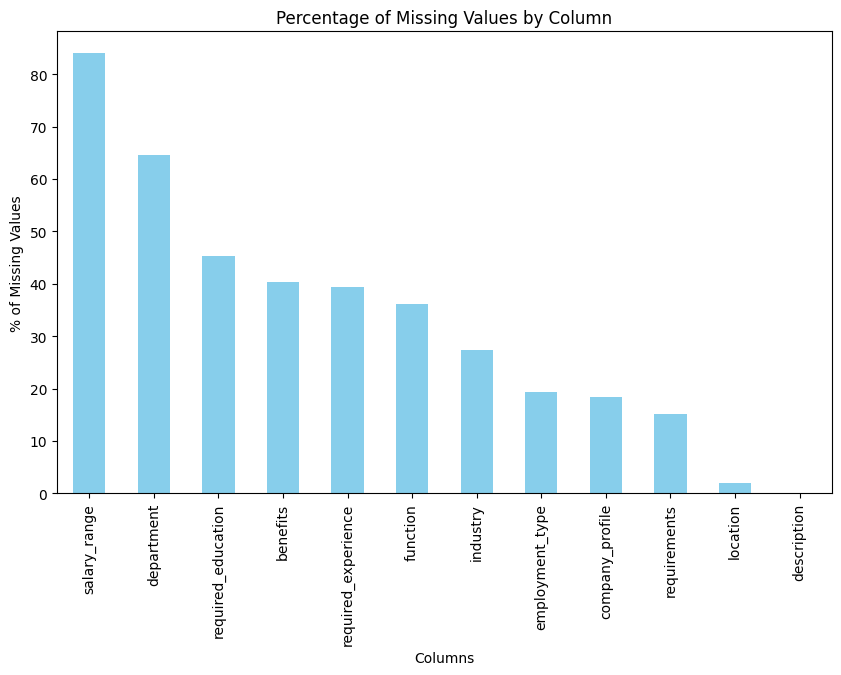

In [19]:
# Count and display percentage of missing values
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
missing_percent.plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values by Column')
plt.ylabel('% of Missing Values')
plt.xlabel('Columns')
plt.show()

In [20]:
# For text columns, replace missing values with Missing
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_columns] = df[text_columns].fillna('Missing')

In [21]:
# For other categorical columns, replace missing values with relevant placeholders
df['location'].fillna('Unknown', inplace=True)
df['department'].fillna('Unknown', inplace=True)
df['salary_range'].fillna('Not Specified', inplace=True)
df['employment_type'].fillna('Not Specified', inplace=True)
df['required_experience'].fillna('Not Specified', inplace=True)
df['required_education'].fillna('Not Specified', inplace=True)
df['industry'].fillna('Not Specified', inplace=True)
df['function'].fillna('Not Specified', inplace=True)

**Some Visualizations**

In [22]:
print("Fraudulent Value Counts:")
print(df['fraudulent'].value_counts())

Fraudulent Value Counts:
fraudulent
0    17014
1      866
Name: count, dtype: int64


In [23]:
# Calculate the total number of job postings
total_postings = len(df)

# Calculate the number of fraudulent postings
fraudulent_postings = df['fraudulent'].value_counts().get(1, 0) 

# Calculate the percentage of fraudulent postings
fraud_percentage = (fraudulent_postings / total_postings) * 100

print(f'Total Job Postings: {total_postings}')
print(f'Number of Fraudulent Postings: {fraudulent_postings}')
print(f'Percentage of Fraudulent Postings: {fraud_percentage:.2f}%')

Total Job Postings: 17880
Number of Fraudulent Postings: 866
Percentage of Fraudulent Postings: 4.84%


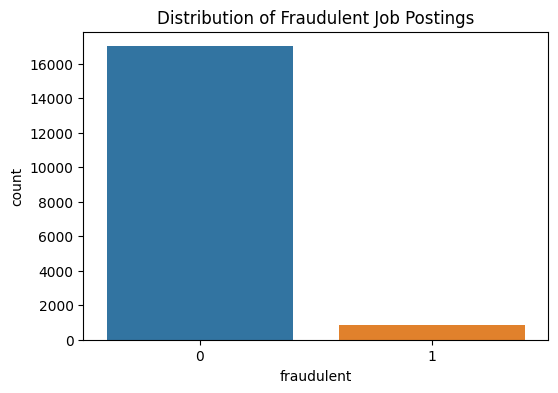

In [24]:
# Bar plot for fraudulent (target) feature
plt.figure(figsize=(6, 4))
sns.countplot(x='fraudulent', data=df)
plt.title('Distribution of Fraudulent Job Postings')
plt.show()

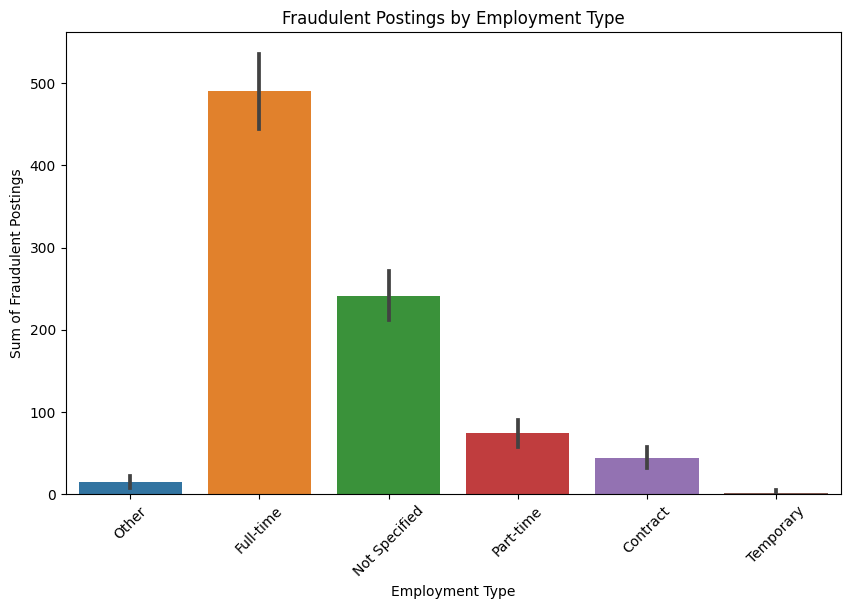

In [25]:
# Bar plot for employment_type
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='employment_type', y='fraudulent', estimator=sum)
plt.title('Fraudulent Postings by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.show()

> Most jobs with fraud are the full time jobs, the least are with Temporary employment

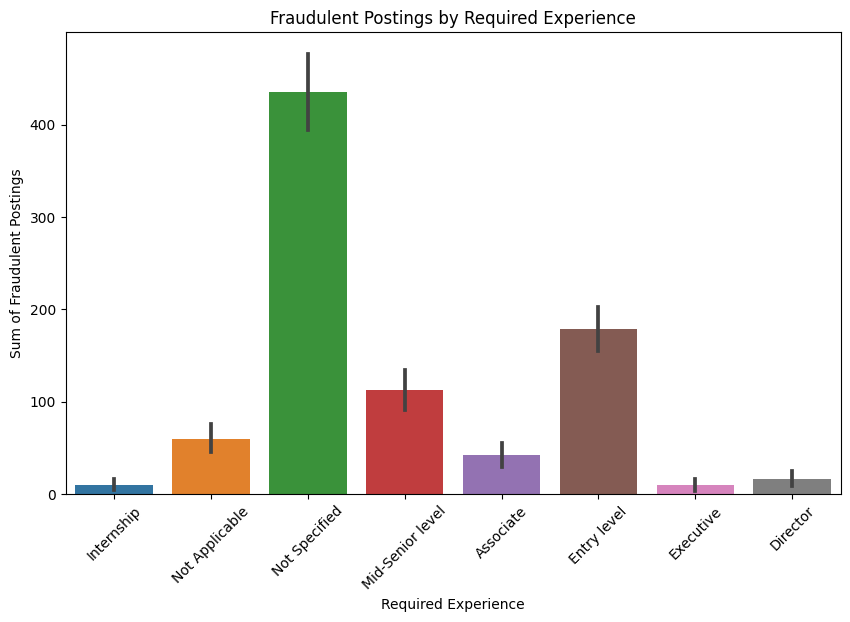

In [26]:
# Bar plot for required_experience
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='required_experience', y='fraudulent', estimator=sum)
plt.title('Fraudulent Postings by Required Experience')
plt.xlabel('Required Experience')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.show()

> Most jobs with fraud are Not Specified in the Required Experience, the least are with Executive and Internship Required Experience

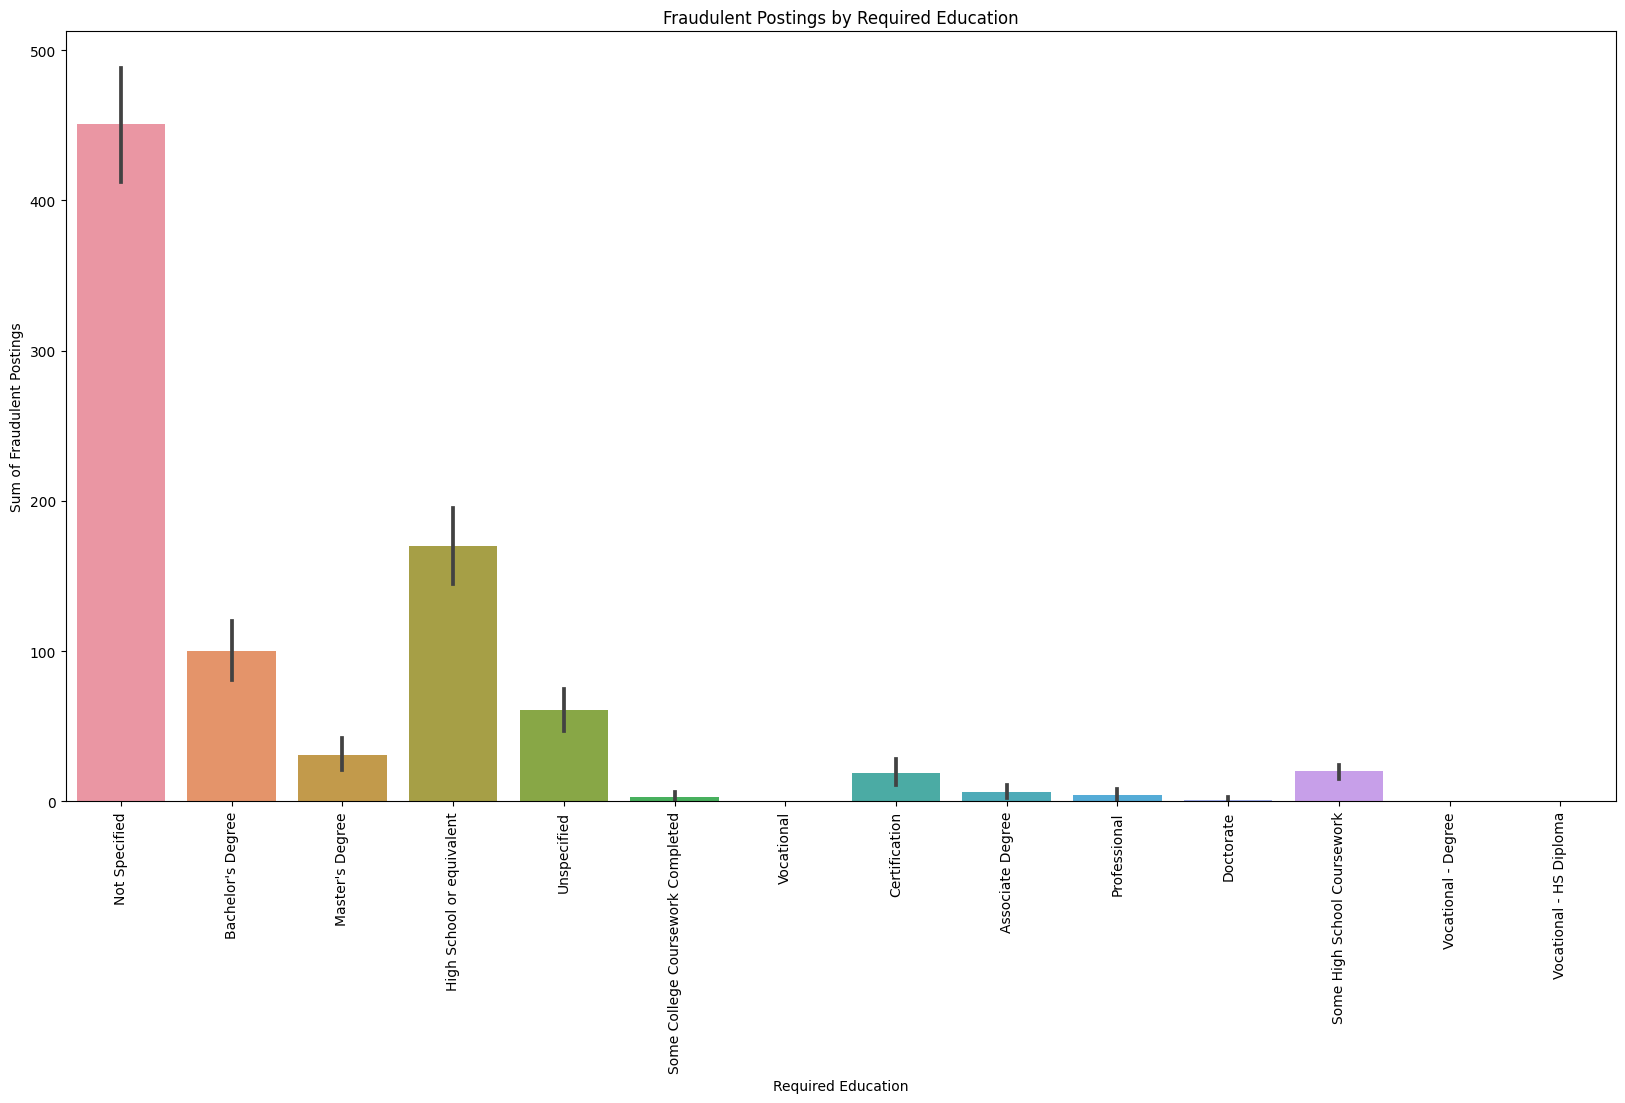

In [27]:
# Bar plot for required_education
plt.figure(figsize=(20, 10))
sns.barplot(data=df, x='required_education', y='fraudulent', estimator=sum)
plt.title('Fraudulent Postings by Required Education')
plt.xlabel('Required Education')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation = 90)
plt.show()

> Not Specified Education is the most that have the posibility of fraud Jop Application, Degrees of vocational or has a degree of Doctorate have the least possibility for being fraud

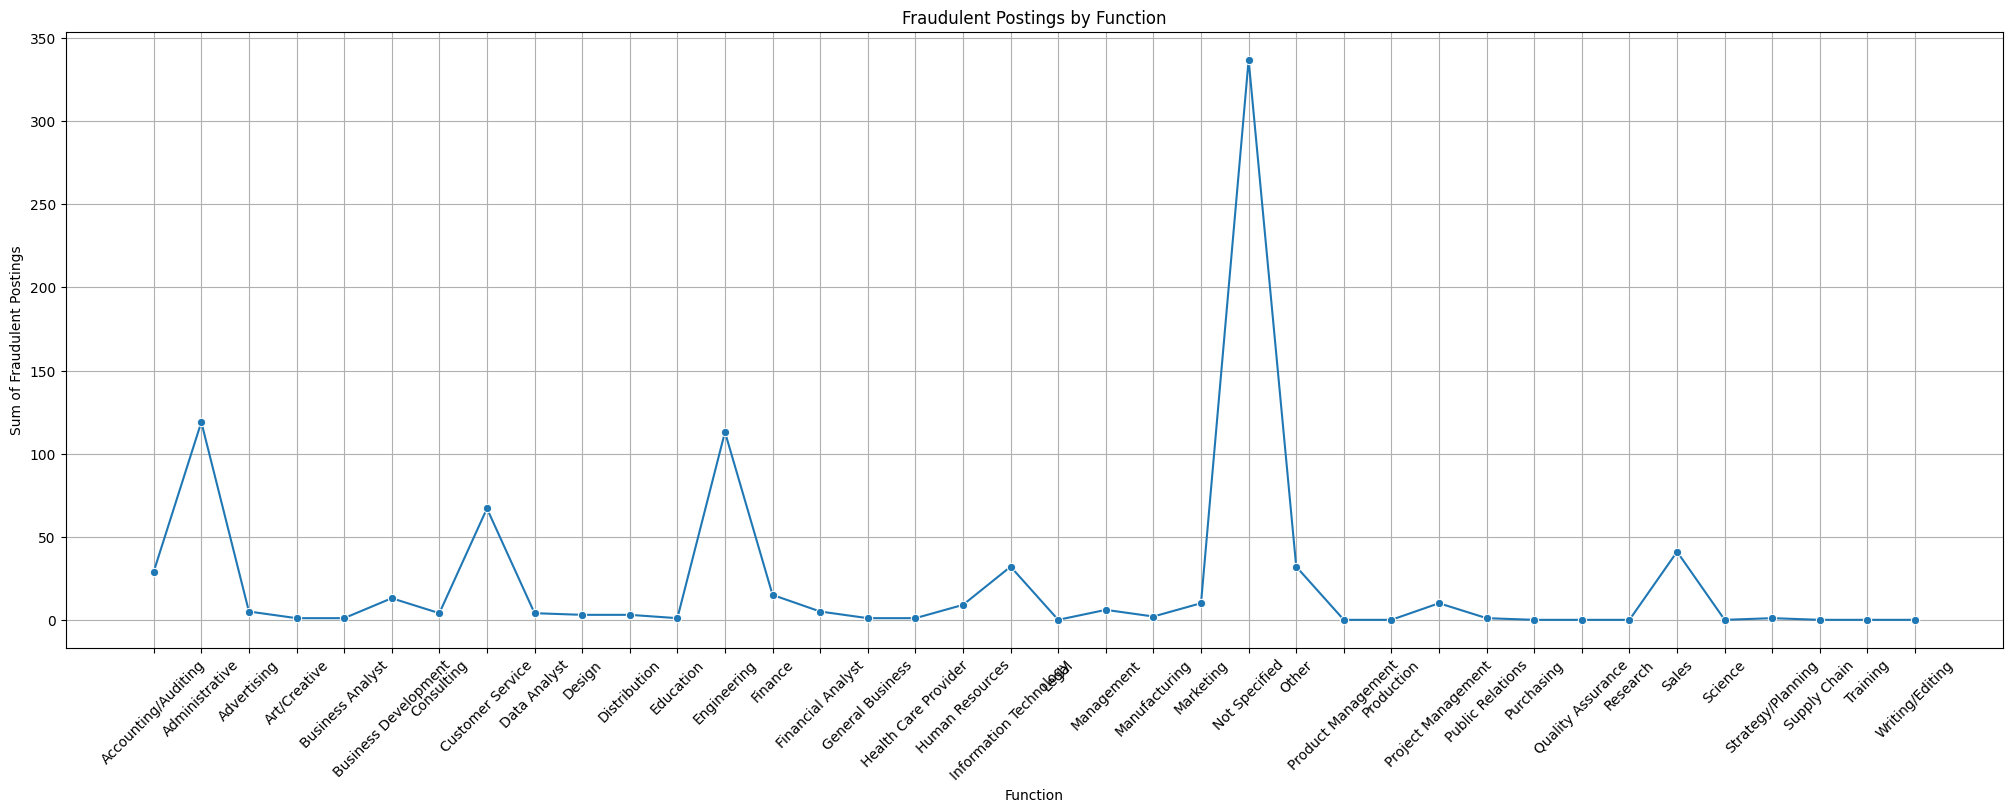

In [28]:
# Calculate the sum of fraudulent postings by function
fraudulent_summary = df.groupby('function')['fraudulent'].sum().reset_index()

plt.figure(figsize=(25, 8))
sns.lineplot(data=fraudulent_summary, x='function', y='fraudulent', marker='o')
plt.title('Fraudulent Postings by Function')
plt.xlabel('Function')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.grid(True) 
plt.show()

> The most Fraud Job Application aren't Specified its Function, the Marketing Sector/ Field have the least opportunity to be Fraud

# **Text preprocessing**

In [29]:
# Text Preprocessing Function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    return text

In [30]:
# Apply preprocessing to relevant text columns
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
for col in text_columns:
    df[col] = df[col].apply(preprocess_text)

# **ML Model by Random Forest Classification**

In [31]:
# Combine Text Features
df['combined_text'] = df[text_columns].agg(' '.join, axis=1)

In [32]:
# Vectorization
# Using TF-IDF for text vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000) 

In [33]:
# Train-Test Split
X = df['combined_text']  # Feature set
y = df['fraudulent']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
# Fit the vectorizer on training data and transform
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [36]:
import pickle
# Save the fitted vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [37]:
# Resampling: Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_tfidf, y_train)

In [38]:
# Check the new class distribution after SMOTE
smote_class_distribution = pd.Series(y_smote).value_counts(normalize=True)
print("New Class Distribution after SMOTE:\n", smote_class_distribution)

New Class Distribution after SMOTE:
 fraudulent
0    0.5
1    0.5
Name: proportion, dtype: float64


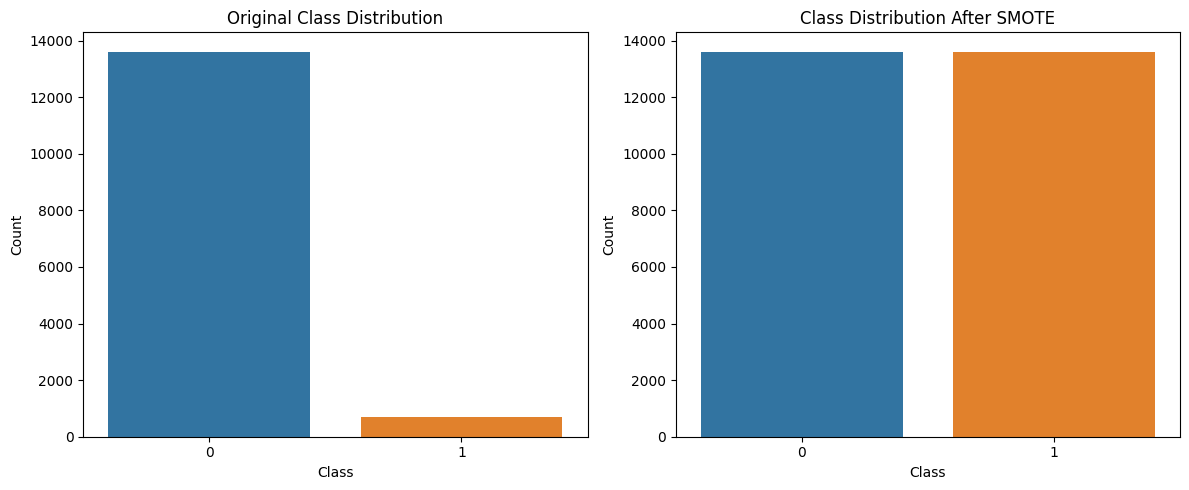

In [39]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=y_smote)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [40]:
# Model Selection and Training
model = RandomForestClassifier(random_state=42)
model.fit(X_smote, y_smote) 

RandomForestClassifier(random_state=42)

In [41]:
# Evaluation
y_pred = model.predict(X_test_tfidf)

In [42]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.99      0.65      0.79       173

    accuracy                           0.98      3576
   macro avg       0.99      0.83      0.89      3576
weighted avg       0.98      0.98      0.98      3576



In [43]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[3402    1]
 [  60  113]]


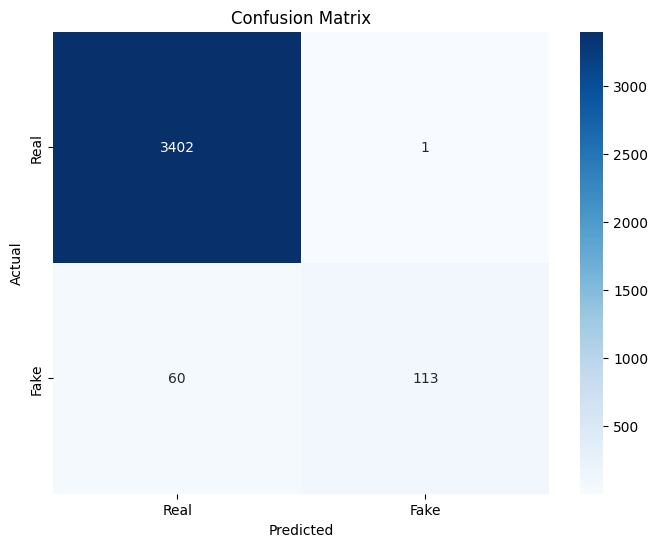

In [44]:
# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [45]:
import pickle

# create an iterator object with write permission - model.pkl
with open('model_pkl', 'wb') as files:
    pickle.dump(model, files)